## Data Wrangling & Exploratory Data Analysis: Chatbot 'Yoldi' 

This notebook encompasses the initial stages of developing a chatbot, 'Yoldi', designed to automate responses for AppleSupport on social media platforms. The key steps in this notebook include:

### 1. Data Acquisition
- **Objective**: Load the dataset from the provided CSV file, focusing specifically on tweets related to AppleSupport.
- **Methodology**: Use PostgreSQL to create a database, called customer_support, create the schema and set it up. Then, upload the csv file to the database. Finally, use SQL to randomly sample the dataset and optimize processing. 

### 2. Data Wrangling and Cleaning
- **Objective**: Prepare the dataset for analysis and model training.
- **Steps Involved**:
  - Filter out inbound queries(users) and responses from Customer Support.
  - Handle missing data, duplicates, and other data inconsistencies.
  - Link user queries with corresponding Customer Support responses.

### 3. Exploratory Data Analysis (EDA)
- **Objective**: Gain insights from the data through visualization and basic statistics.
- **Techniques Used**:
  - Visualize the distribution of queries over time.
  - Analyze the common themes or topics in customer queries.
  - Understand the response patterns of Customer Support.

### 4. Initial Data Insights
- **Objective**: Draw preliminary conclusions from the EDA.
- **Key Areas**:
  - Understanding the nature and complexity of queries.
  - Assessing the efficiency of customer support responses.


In [74]:
import logging
import html
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import dotenv
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Boolean, DateTime
import psycopg2
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
from gensim.corpora.dictionary import Dictionary

#### Data Acquisition: PostgreSQL

In [ ]:
# # Fetching the password from environment variable
# db_password = os.environ.get('DATABASE_PASSWORD')

# # Ensure the password is set
# if db_password is None:
#     raise ValueError("Database password environment variable not set")

# # Database connection details
# username = 'postgres'  # replace with your username
# host = 'localhost'
# database = 'customer_support'
# db_password = 'DePorLo******'

# # Creating database connection URL
# db_url = f"postgresql://{username}:{db_password}@{host}/{database}"

# # Create a database engine
# engine = create_engine(db_url)

# # testing the connection
# try:
#     with engine.connect() as conn:
#         print("Successfully connected to the database!")
# except Exception as e:
#     print(f"An error occurred: {e}")


In [ ]:
# # creating table - define metadata
# metadata = MetaData()

# # Define the 'tweets' table
# tweets_table = Table('tweets', metadata,
#                      Column('tweet_id', Integer, primary_key=True),
#                      Column('author_id', String),
#                      Column('inbound', Boolean),
#                      Column('created_at', DateTime),
#                      Column('text', String),
#                      Column('response_tweet_id', Integer),
#                      Column('in_response_to_tweet_id', Integer)
#                     )

# # creating the table
# metadata.create_all(engine)

In [ ]:
# conn_info = "dbname='customer_support' user='postgres' host='localhost' password='DePorLo*****'"
# conn = psycopg2.connect(conn_info)
# cur = conn.cursor()

# with open('../data/raw/twcs.csv', 'r') as f:
#     cur.copy_expert("COPY tweets FROM STDIN WITH CSV HEADER", f)
#     conn.commit()

# cur.close()
# conn.close()

In [9]:
dotenv_path = os.path.join(os.getcwd(), '.env')
# Load the .env file
dotenv.load_dotenv(dotenv_path)

# Retrieve the environment variable
db_password = os.environ.get('DATABASE_PASSWORD')
if db_password is None:
    raise ValueError("Database password environment variable not set")
else:
    print("Database password loaded successfully")

Database password loaded successfully


In [4]:
DB_USERNAME = 'postgres'
DB_PASSWORD = os.environ.get('DATABASE_PASSWORD')
DB_HOST = 'localhost'
DB_NAME = 'customer_support'
SAMPLE_QUERY = "SELECT * FROM tweets ORDER BY RANDOM() LIMIT 250000;"

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to create a database engine
def create_db_engine(username, password, host, database):
    try:
        db_url = f"postgresql://{username}:{password}@{host}/{database}"
        engine = create_engine(db_url)
        logging.info("Database engine created successfully")
        return engine
    except Exception as e:
        logging.error(f"Error creating database engine: {e}")
        raise

# Function to test database connection
def test_db_connection(engine):
    try:
        with engine.connect() as conn:
            logging.info("Successfully connected to the database")
    except Exception as e:
        logging.error(f"An error occurred while connecting to the database: {e}")
        raise

# Fetching the password from environment variable
db_password = os.environ.get('DATABASE_PASSWORD')
if db_password is None:
    raise ValueError("Database password environment variable not set")

# creating engine and testing
engine = create_db_engine(DB_USERNAME, DB_PASSWORD, DB_HOST, DB_NAME)
test_db_connection(engine)

# function to sample data
def sample_data(conn, query):
    """Sample data from the database.
    conn: connection previously created for the database.
    query: PostgreSQL query to sample the data.
    Returns: dataframe.
    """

    try:
        logging.info("Starting function execution: sample_data")
        return pd.read_sql_query(query, conn)
    except Exception as e:
        logging.error(f"Error in your_function: {e}")
        raise
    else:
        logging.info("Completed execution of function: sample_data")
    
# executing function to sample data and save it to folder as csv
sampled_data = sample_data(engine, SAMPLE_QUERY)
sampled_data.to_csv('../data/raw/df_sample.csv', index=False)


2023-11-22 20:49:02,119 - INFO - Database engine created successfully
2023-11-22 20:49:02,169 - INFO - Successfully connected to the database
2023-11-22 20:49:02,170 - INFO - Starting function execution: sample_data


### Data Loading: 

We retrieved the raw data from kaggle. Then, we will load it to the variable df

In [10]:
# file path
file_path = '../data/raw/df_sample.csv'

#function to load
def load_data(file_path, chunk_size=1000):
    """
    Load data from a CSV file in chunks to manage memory usage.
    """
    try:
        logging.info("Starting execution of load_data")
        chunk_list = []
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            chunk_list.append(chunk)
        df = pd.concat(chunk_list, ignore_index=True)
        logging.info("Data loading completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error loading data from %s: %s:", file_path, e)
        return None

# loading data to df
df = load_data(file_path=file_path)
# checking dataframe 
df.head(10)

2023-11-22 22:14:42,796 - INFO - Starting execution of load_data
2023-11-22 22:14:43,724 - INFO - Data loading completed successfully


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,2149594,Tesco,False,2017-11-09 00:55:53,@535047 Can you please confirm the requested d...,NaN,2149595.0
1,1561881,482478,True,2017-11-04 04:57:53,What's with the pricing @GoDaddyHelp?\n$12.96....,"1561882,1561883,1561880",NaN
2,1956537,SpotifyCares,False,2017-10-30 17:24:43,@580626 Hey Henry! It's an easter egg for the ...,NaN,1956538.0
3,1495379,AskCiti,False,2017-11-05 00:32:31,@467204 Hello. We haven't heard from u. If u s...,NaN,1495377.0
4,582530,ATVIAssist,False,2017-12-03 13:19:03,"@257338 Apologies for the delay, please provid...",NaN,582531.0
5,2077646,135058,True,2017-10-09 07:41:35,"@AppleSupport hey, I didn’t use a flashlight m...","2077647,2077645",NaN
6,1067207,371845,True,2017-10-14 20:26:51,@115888 funny how a song that brags about sayi...,1067206,NaN
7,2792850,UPSHelp,False,2017-11-21 21:08:00,"@779420 Also, with your phone number I can fil...",2792851,2792852.0
8,2181045,639075,True,2017-11-09 18:31:34,@VirginTrains Now I'm connected and slow! Not ...,2181046,2181044.0
9,2737067,comcastcares,False,2017-11-20 20:39:51,@766954 The last DM from you was in July. We w...,NaN,2737065.0


#### Data Cleaning: 

Below we clean the data as a preparation for exploring it in EDA further below.

In [11]:
# function to perform basic cleaning text for more advanced cleaning and preprocessing
def custom_clean_text(text):
    """
    Perform custom cleaning of text data.

    Args:
    text (str): The text to be cleaned.

    Returns:
    str: Cleaned text.
    """
    try:
        # Decode HTML entities
        text = html.unescape(text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Remove extra spaces, new lines
        text = ' '.join(text.split())
        # Convert to lowercase
        text = text.lower()
        return text
    except Exception as e:
        logging.error(f"Error in cleaning text: {e}")
        # Optionally, you can return None or some default value if error occurs
        return None

# error handling testing function
try:
    df['cleaned_text'] = df['text'].apply(custom_clean_text)
    logging.info("Text cleaning completed successfully")
except Exception as e:
    logging.error(f"Error during text cleaning process: {e}")

# dropping columns
df.dropna(subset=['text', 'created_at'], inplace=True)
df.drop_duplicates(subset=['tweet_id'], inplace=True)
df['created_at'] = pd.to_datetime(df['created_at'])


2023-11-22 22:14:52,293 - INFO - Text cleaning completed successfully


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tweet_id                 250000 non-null  int64         
 1   author_id                250000 non-null  object        
 2   inbound                  250000 non-null  bool          
 3   created_at               250000 non-null  datetime64[ns]
 4   text                     250000 non-null  object        
 5   response_tweet_id        157212 non-null  object        
 6   in_response_to_tweet_id  179666 non-null  float64       
 7   cleaned_text             250000 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 13.6+ MB


In [13]:
# initializing spacy 
nlp = spacy.load('en_core_web_sm')

In [14]:
# batch processing with spacy: advanced NLP preprocessing

def batch_spacy_preprocessing(texts, batch_size=1000):
    """
    Process a batch of texts using SpaCy for NLP tasks such as lemmatization, 
    part-of-speech tagging, and dependency parsing.
    Args:
    texts (list of str): A list of texts to be processed.
    batch_size (int): The number of texts to process in each batch.
    Returns:
    tuple: Three lists containing the processed texts, POS tags, and dependency parses.
    """
    try:
        # Load SpaCy model
        nlp = spacy.load('en_core_web_sm')
        processed_texts, pos_tags, dep_parses = [], [], []

        # Process texts in batches
        for doc in nlp.pipe(texts, batch_size=batch_size):
            if doc.is_parsed:
                doc_lemmas = [token.lemma_ for token in doc if not token.is_stop]
                doc_pos_tags = [token.pos_ for token in doc]
                doc_dep_parse = [token.dep_ for token in doc]
            else:
                doc_lemmas, doc_pos_tags, doc_dep_parse = None, None, None

            processed_texts.append(' '.join(doc_lemmas) if doc_lemmas else None)
            pos_tags.append(doc_pos_tags)
            dep_parses.append(doc_dep_parse)

        logging.info("Spacy batch processing completed successfully")
        return processed_texts, pos_tags, dep_parses
    except Exception as e:
        logging.error(f"Error in Spacy batch processing: {e}")
        # Optionally return a default value or empty lists if error occurs
        return [], [], []

# apply spacy batch processing
texts = df['text'].astype(str).tolist()
df['processed_text'], df['pos_tags'], df['dep_parse'] = batch_spacy_preprocessing(texts)

/var/folders/fk/kvpxv24d2ys_slgf4kqk23f40000gn/T/ipykernel_50541/1154690766.py:20: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:
2023-11-22 23:19:39,748 - INFO - Spacy batch processing completed successfully


In [15]:
nltk.download('vader_lexicon')

# initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the processed text
df['sentiment'] = df['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'] if x else 0)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/camilods16/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# defining functions for linking customer queries with responses
def link_queries_responses(df):
    """
    Link inbound queries with their corresponding outbound responses in a DataFrame.
    df (pd.DataFrame): DataFrame containing customer support data with 'inbound', 
                       'tweet_id', and 'in_response_to_tweet_id' columns.
    Returns:
    pd.DataFrame: A DataFrame with linked inbound and outbound queries.
    """
    try:
        # Filter for inbound and outbound tweets
        df_inbound = df[df['inbound'] == True]
        df_outbound = df[df['inbound'] == False]

        # Merge inbound and outbound dataframes
        df_linked = pd.merge(df_inbound, df_outbound, left_on='tweet_id', right_on='in_response_to_tweet_id', how='left', suffixes=('_inbound', '_outbound'))

        logging.info("Queries and responses linked successfully")
        return df_linked
    except Exception as e:
        logging.error(f"Error in linking queries and responses: {e}")
        # raise the exception
        raise e


# creating a df of inbound queries and their responses by linking them
df_linked = link_queries_responses(df)

2023-11-23 09:42:06,833 - INFO - Queries and responses linked successfully


In [66]:
# NER with SpaCy
def advanced_text_analysis(df):
    """
    Perform advanced text analysis for sentiment and Named Entity Recognition (NER) on a DataFrame.
    df (pd.DataFrame): DataFrame containing a column 'processed_text' for analysis.
    Returns:
    pd.DataFrame: The input DataFrame with an additional 'entities' column containing NER results.
    """
    try:
        # apply Named Entity Recognition
        df['entities'] = df['processed_text'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents] if x else [])
        logging.info("Advanced text analysis (NER) completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error in advanced text analysis: {e}")
        # raise the exception
        raise e

# applying function
df = advanced_text_analysis(df)

2023-11-23 16:36:39,342 - INFO - Advanced text analysis (NER) completed successfully


In [23]:
# creating a column sentiment_class
def classify_sentiment(score):
    """
    Classify the sentiment of the tweets based on a sentiment score.
    Returns 'Positive', 'Negative', or 'Neutral' based on the score.
    score (float): The sentiment score to classify.
    Returns:
    str: The sentiment classification ('Positive', 'Negative', 'Neutral').
    """
    try:
        if score > 0.1:
            return 'Positive'
        elif score < -0.1:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception as e:
        logging.error(f"Error in classifying sentiment: {e}")
        # Optionally, return a default classification or raise the exception
        return 'Neutral'  # or, raise e

# applying sentiment classification with threshold
try:
    df['sentiment_class'] = df['sentiment'].apply(classify_sentiment)
    logging.info("Sentiment classification applied successfully")
except Exception as e:
    logging.error(f"Error applying sentiment classification to DataFrame: {e}")


2023-11-23 11:09:02,810 - INFO - Sentiment classification applied successfully


#### EDA: Exploratory Data Analysis

In this stage we take the data previously cleaned and we start aggregating when necessary to create visualizations that will provide insights from the data. 

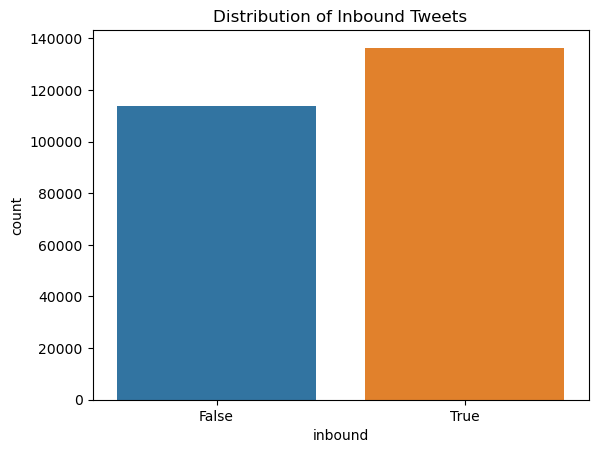

In [36]:
# EDA Functions
def plot_tweet_distribution(df, column='inbound'):
    """
    Visualize the distribution of tweets.
    """
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column.capitalize()} Tweets')
    plt.show()

# plotting the distribution
plot_tweet_distribution(df=df)

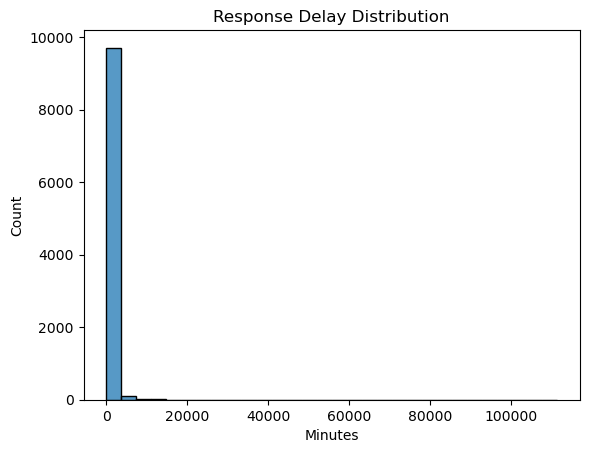

In [37]:
# conversation flow analysis plot
def conversation_flow_analysis(df):
    """
    Analyze the flow of conversations by looking at response delays.
    """
    df['response_delay'] = (df['created_at_outbound'] - df['created_at_inbound']).dt.total_seconds() / 60
    sns.histplot(df['response_delay'], bins=30)
    plt.title('Response Delay Distribution')
    plt.xlabel('Minutes')
    plt.show()

conversation_flow_analysis(df=df_linked)

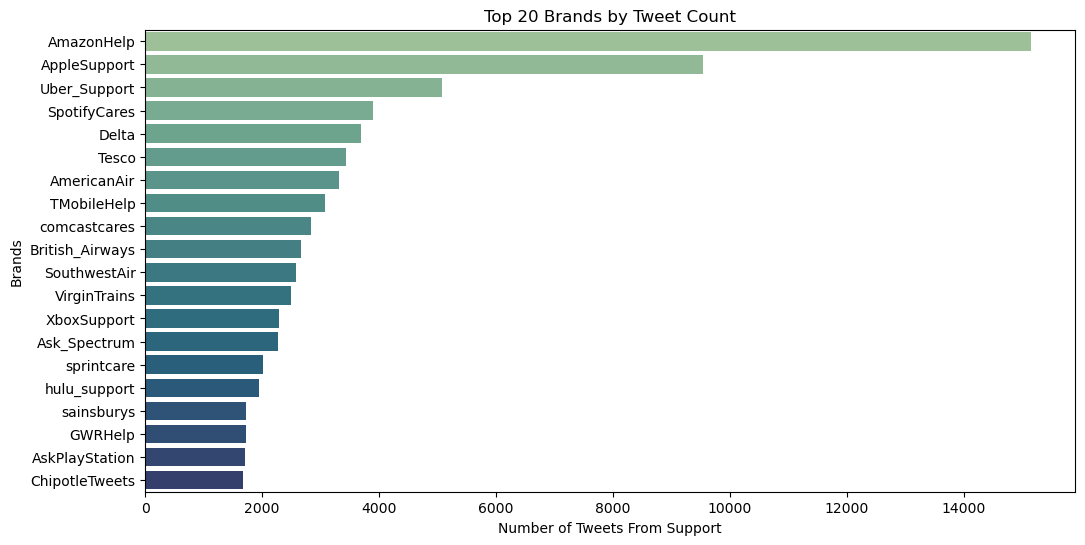

In [38]:
# Plotting the frequency distribution of brands (author_id)
brand_counts = df['author_id'].value_counts().head(20)  # Top 20 brands
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_counts.values, y=brand_counts.index, palette='crest')
plt.title('Top 20 Brands by Tweet Count')
plt.xlabel('Number of Tweets From Support')
plt.ylabel('Brands')
plt.show() 

In [64]:
# rilter the data to include only dates from 2012 onwards
df_filtered = df[df['created_at'].dt.year >= 2012]
# Aggregate sentiment scores by week or month and calculate the mean
# # For monthly average:
monthly_sentiment = df_filtered.resample('M', on='created_at')['sentiment'].mean().reset_index()
# Choose one of the above, then apply a rolling window
rolling_window_size = 7  # 7 periods rolling average
monthly_sentiment['rolling_sentiment'] = monthly_sentiment['sentiment'].rolling(window=rolling_window_size, min_periods=1).mean()

# plotting monthly sentiment 
fig = px.line(monthly_sentiment, x='created_at', y='rolling_sentiment', title='Monthly Sentiment Score Over Time - Rolling Average')
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Average Sentiment Score')
fig.show()

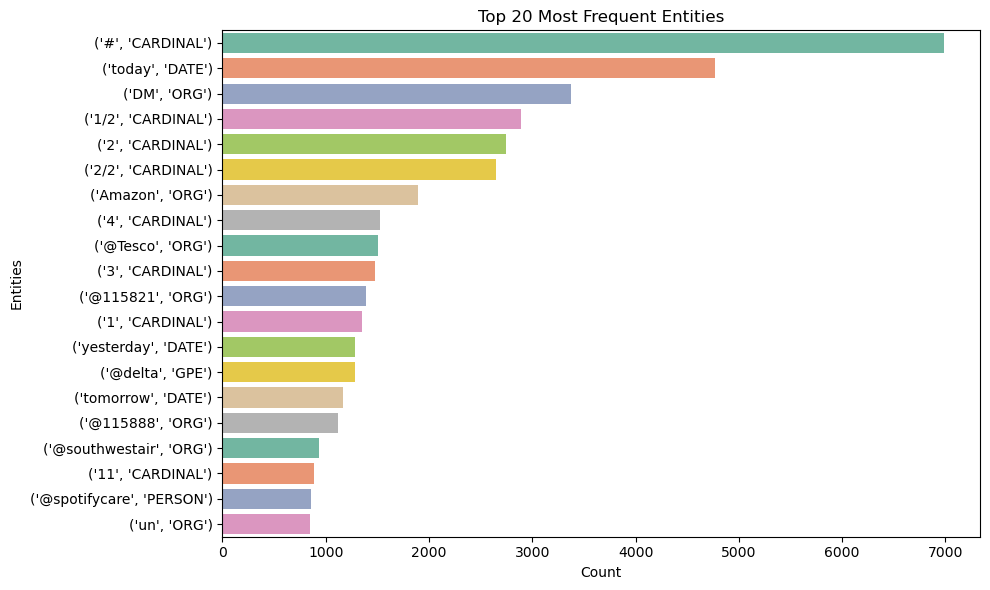

In [69]:
# function to identify the top entities with the NER column created
def most_frequent_entities(df, column='entities', top_n=20):
    """
    Find and visualize the most frequent entities in a DataFrame.
    df (pd.DataFrame): DataFrame containing the entities.
    column (str): The name of the column in df that contains the entities.
    top_n (int): The number of top entities to return.
    Returns:
    pd.DataFrame: A DataFrame containing the top entities and their counts.
    """
    # Flatten the list of entities
    all_entities = [ent for sublist in df[column] for ent in sublist]
    # Count the entities
    entity_counts = Counter(all_entities)
    # Get the top n entities
    top_entities = entity_counts.most_common(top_n)
    # Convert to DataFrame for better visualization
    top_entities_df = pd.DataFrame(top_entities, columns=['Entity', 'Count'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Entity', data=top_entities_df, palette='Set2')
    plt.title(f'Top {top_n} Most Frequent Entities')
    plt.xlabel('Count')
    plt.ylabel('Entities')
    plt.tight_layout()
    plt.show()

    return top_entities_df
# applying the function and visualizing the top entities
top_entities_df = most_frequent_entities(df)

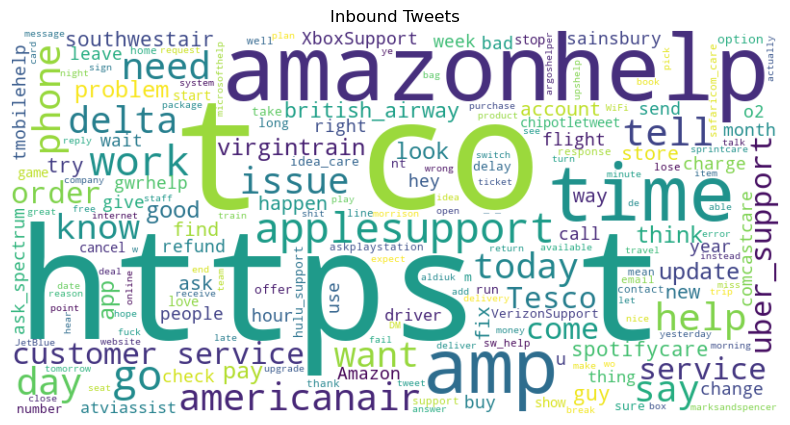

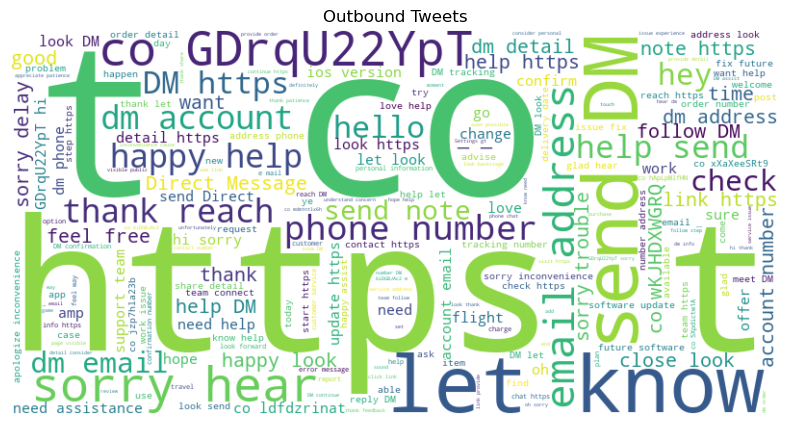

In [73]:

# generate word clouds functiion 
def generate_word_clouds(df):
    inbound_text = ' '.join(df[df['inbound']]['processed_text'].dropna())
    outbound_text = ' '.join(df[~df['inbound']]['processed_text'].dropna())

    for text, title in zip([inbound_text, outbound_text], ['Inbound Tweets', 'Outbound Tweets']):
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis('off')
        plt.show()
    return wordcloud

# applying the function
generate_word_clouds(df)

In [80]:
# creating a function: perform topic modeling 
def perform_topic_modeling(df, column='processed_text', num_topics_range=(5, 15), workers=None):
    # Filter out None values before applying any text processing
    df = df.dropna(subset=[column])
    
    # Continue with processing as before
    texts = df[column].apply(lambda x: x.split())
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    best_coherence = 0
    best_model = None
    best_num_topics = 0
    
    for num_topics in range(*num_topics_range, 5):  # Using a step of 5 for a broader search
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=workers, passes=5)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_model = model
            best_num_topics = num_topics
    
    print(f"Initial Exploration - Best Number of Topics: {best_num_topics}, Coherence Score: {best_coherence}")
    return best_model, best_num_topics

# Adjust num_topics_range based on your initial exploration needs
best_model, best_num_topics = perform_topic_modeling(df, num_topics_range=(5, 15), workers=4)

2023-11-23 17:22:01,247 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2023-11-23 17:22:01,387 - INFO - adding document #10000 to Dictionary<21746 unique tokens: ['!', '?', '@535047', 'DM', 'confirm']...>
2023-11-23 17:22:01,518 - INFO - adding document #20000 to Dictionary<36109 unique tokens: ['!', '?', '@535047', 'DM', 'confirm']...>
2023-11-23 17:22:01,654 - INFO - adding document #30000 to Dictionary<48858 unique tokens: ['!', '?', '@535047', 'DM', 'confirm']...>
2023-11-23 17:22:01,786 - INFO - adding document #40000 to Dictionary<60810 unique tokens: ['!', '?', '@535047', 'DM', 'confirm']...>
2023-11-23 17:22:01,918 - INFO - adding document #50000 to Dictionary<72222 unique tokens: ['!', '?', '@535047', 'DM', 'confirm']...>
2023-11-23 17:22:02,043 - INFO - adding document #60000 to Dictionary<83072 unique tokens: ['!', '?', '@535047', 'DM', 'confirm']...>
2023-11-23 17:22:02,175 - INFO - adding document #70000 to Dictionary<93470 unique tokens: ['!', '?', '@53504

Initial Exploration - Best Number of Topics: 10, Coherence Score: 0.4364969571524682
